# Streaming Object-Centric Process Mining with `pyBeamline`

pyBeamline is based on ReactiveX and its Python binding RxPY. RxPY is a library for composing asynchronous and event-based programs using observable sequences and pipable query operators in Python. Using pyBeamline it is possible to inject process mining operators into the computation.

This Jupyter notebook contains the main contributions towards Streaming Object-Centric Process Discovery. The rest of the notebook it is assumed that the `pyBeamline` package is already installed.

In the rest of this document, the main functionalities are exposed.

It is possible to install the library using:

In [1]:
#!pip install pybeamline # Note: Uncomment this line when meged into the main branch of pyBeamline
# Let's ignore some PM4PY warnings in the notebook
import warnings

from pybeamline.algorithms.oc.strategies.base import RelativeFrequencyBasedStrategy, LossyCountingStrategy, \
    SlidingWindowStrategy
from pybeamline.models.ocdfg import OCDFG

warnings.filterwarnings("ignore")

In [2]:
import importlib
import pybeamline
importlib.reload(pybeamline) # NOTE: To-be removed when integrated in pyBeamline master

<module 'pybeamline' from 'C:\\Users\\Admin\\Documents\\work\\dtu\\pybeamline\\__init__.py'>

## Sources

The `pyBeamline` library provides two main object-centric sources:
1. `OCEL 2.0`: Object-Centric Event Log (OCEL) 2.0 source reads an OCEL file and emits object-centric events.
2. `Dictionary Test Source`: A test source that can be initialized with a list of dictionaries, each representing an object-centric event trace.

First lets consider the test source, which is useful for testing purposes:

In [2]:
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source

# Consider two traces with different activities and objects for demonstration
# IMPORTANT: Object identifiers (e.g., "c1", "o1") must be unique across traces.
# Note: Specifying an object (e.g., "c1") in a trace implies that across all generated instances of `trace_1` by adding suffixes,
# that object maintains consistent relationships with the activities as defined in the trace structure, i.e, object "c1" goes from "Register Customer" to "Create Order", and so on.
trace_1 = [
            {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
            {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
            {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
            {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i2"]}},
            {"activity": "Ship Order", "objects": {"Item": ["i1", "i2"], "Order": ["o1"]}}
        ]

trace_2 = [
            {"activity": "Register Guest", "objects": {"Guest": ["g1"]}},
            {"activity": "Create Booking", "objects": {"Guest": ["g1"], "Booking": ["b1"]}},
            {"activity": "Reserve Room", "objects": {"Booking": ["b1"]}},
            {"activity": "Check In", "objects": {"Guest": ["g1"], "Booking": ["b1"]}},
            {"activity": "Check Out", "objects": {"Guest": ["g1"], "Booking": ["b1"]}}
        ]

# One can create the test source with a list of traces, where each trace is a tuple containing the trace structure and the number of times it should be repeated.
test_source = dict_test_ocel_source(
    [
        (trace_1, 2),  # Repeat trace_1 twice
        (trace_2, 3)   # Repeat trace_2 three times
    ],
    shuffle = True  # Shuffle the traces for variability
                    # Note: The shuffle works by shuffling the order of traces as a whole, not the activities within each trace.
)

test_source.subscribe(
    on_next=lambda x: print(str(x))
)

{'ocel:eid': 'e0', 'ocel:activity': 'Register Guest', 'ocel:timestamp': datetime.datetime(2026, 1, 19, 16, 3, 43, 829861), 'ocel:omap': {'Guest': {'g1_3'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e1', 'ocel:activity': 'Create Booking', 'ocel:timestamp': datetime.datetime(2026, 1, 19, 16, 3, 43, 829861), 'ocel:omap': {'Guest': {'g1_3'}, 'Booking': {'b1_3'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e2', 'ocel:activity': 'Reserve Room', 'ocel:timestamp': datetime.datetime(2026, 1, 19, 16, 3, 43, 829861), 'ocel:omap': {'Booking': {'b1_3'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e3', 'ocel:activity': 'Check In', 'ocel:timestamp': datetime.datetime(2026, 1, 19, 16, 3, 43, 829861), 'ocel:omap': {'Guest': {'g1_3'}, 'Booking': {'b1_3'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e4', 'ocel:activity': 'Check Out', 'ocel:timestamp': datetime.datetime(2026, 1, 19, 16, 3, 43, 829861), 'ocel:omap': {'Guest': {'g1_3'}, 'Booking': {'b1_3'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e5', 'ocel:activity': 'Register Customer', 'ocel:timestamp': dat

In [46]:
#!wget https://raw.githubusercontent.com/beamline/pybeamline/refs/heads/master/tests/logistics.jsonocel

In [3]:
# Now let's consider the OCEL 2.0 source, which reads an OCEL file and emits object-centric events.
from pybeamline.sources.ocel2_log_source_from_file import ocel2_log_source_from_file

from pybeamline.mappers.print_operator import print_operator
from pybeamline.mappers.take_mapper import take
from pybeamline.sources.ocel2_log_source_from_file import ocel2_log_source_from_file

# Assuming you have an OCEL file
source = ocel2_log_source_from_file("tests/logistics.jsonocel")

source.pipe(
    take(10),  # Limit to the first 10 events for demonstration
    print_operator()
).subscribe(on_next=print)

C:\Users\Admin\Documents\work\dtu\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


{'ocel:eid': 'reg_co1', 'ocel:activity': 'Register Customer Order', 'ocel:timestamp': Timestamp('2023-05-22 11:54:42+0000', tz='UTC'), 'ocel:omap': {'Customer Order': ['co1']}, 'ocel:vmap': {}}
{'ocel:eid': 'reg_co1', 'ocel:activity': 'Register Customer Order', 'ocel:timestamp': Timestamp('2023-05-22 11:54:42+0000', tz='UTC'), 'ocel:omap': {'Customer Order': ['co1']}, 'ocel:vmap': {}}
{'ocel:eid': 'reg_co2', 'ocel:activity': 'Register Customer Order', 'ocel:timestamp': Timestamp('2023-05-22 18:33:30+0000', tz='UTC'), 'ocel:omap': {'Customer Order': ['co2']}, 'ocel:vmap': {}}
{'ocel:eid': 'reg_co2', 'ocel:activity': 'Register Customer Order', 'ocel:timestamp': Timestamp('2023-05-22 18:33:30+0000', tz='UTC'), 'ocel:omap': {'Customer Order': ['co2']}, 'ocel:vmap': {}}
{'ocel:eid': 'create_td1', 'ocel:activity': 'Create Transport Document', 'ocel:timestamp': Timestamp('2023-05-23 08:22:17+0000', tz='UTC'), 'ocel:omap': {'Customer Order': ['co2'], 'Transport Document': ['td1']}, 'ocel:vmap'

## Discovery Techniques

### `oc_operator` – Streaming Object-Centric Process Mining Operator
The `oc_operator` function configures and returns a **reactive operator** that enables **real-time discovery of object-centric process models** and **activity-entity relationship (AER) diagrams** from a stream of `BOEvent` events.

#### Parameters

| Parameter                    | Type                                              | Description                                                                                                        |
| ---------------------------- |---------------------------------------------------| ------------------------------------------------------------------------------------------------------------------ |
| `inclusion_strategy`         | `InclusionStrategy` (optional)                    | Determines when object types are considered active/inactive (e.g., based on relative frequency or lossy counting). |
| `control_flow`               | `Dict[str, Callable[[], StreamMiner]]` (optional) | Predefined miners for each object type (static mode).                                                              |
| `aer_model_update_frequency` | `int`  (optional)                                 | Frequency (in #events) for emitting AER model updates.                                                             |
| `aer_model_max_approx_error` | `float` (optional)                                | Maximum error tolerance for lossy counting in AER miner (lower = more accurate but higher memory).                 |
| `default_miner`              | `Callable[[], StreamMiner]` (optional)            | Miner to use in dynamic mode for unseen object types.                                                              |

#### Modes of Operation

* **Static Mode**: You provide a `control_flow` dictionary that maps object types to specific miners. Thereby only selected object types are processed, and miners are created based on the provided functions.
* **Dynamic Mode**: If `control_flow` is not provided, miners are created *on-the-fly* using `default_miner`.

#### Outputs

An `Observable[dict]` stream where each message is of one of the following types:

* `{"type": "dfg", "object_type": ..., "model": ...}`
  → Object-type-specific control-flow models (e.g., Heuristics Net / DFG)

* `{"type": "aer", "model": ...}`
  → Activity-Entity Relationship diagrams across all object types

* `{"type": "command", "command": ACTIVE/INACTIVE, "object_type": ...}`
  → Inclusion/exclusion signals for adaptive concept drift handling




In [4]:
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.algorithms.discovery import heuristics_miner_lossy_counting, heuristics_miner_lossy_counting_budget
from pybeamline.algorithms.oc.oc_merge_operator import oc_merge_operator

# By supplying control_flow, static mode is activated.
# Only these object types will be processed, and the miners will be created based on the provided functions.
control_flow = {
    "Customer": lambda : heuristics_miner_lossy_counting(
        model_update_frequency=5,
        max_approx_error=0.2
    ),
    "Order": lambda : heuristics_miner_lossy_counting_budget( # Individual tuning for Order
        model_update_frequency=4,
    ),
    "Item": lambda : heuristics_miner_lossy_counting(
        model_update_frequency=4,
        max_approx_error=0.1
    )
}
print("Static mode with control flow:")

test_source.pipe(
    oc_operator(control_flow=control_flow),
).subscribe(
    on_next=print
)
print("--" * 50)
print("Dynamic mode with default miner:")

test_source.pipe(
    oc_operator(
        default_miner=lambda: heuristics_miner_lossy_counting(
            model_update_frequency=4,
            max_approx_error=0.1
        )
    ),
).subscribe(on_next=print)

Static mode with control flow:
{'type': 'command', 'command': <Command.ACTIVE: 'active'>, 'object_type': 'Item'}
{'type': 'dfg', 'object_type': 'Item', 'model': {'Add Item': (node:Add Item connections:{Ship Order:[0.5]}), 'Ship Order': (node:Ship Order connections:{})}}
{'type': 'command', 'command': <Command.ACTIVE: 'active'>, 'object_type': 'Order'}
{'type': 'dfg', 'object_type': 'Order', 'model': {'Create Order': (node:Create Order connections:{Add Item:[0.5]}), 'Add Item': (node:Add Item connections:{Add Item:[0.5], Ship Order:[0.5]}), 'Ship Order': (node:Ship Order connections:{})}}
{'type': 'command', 'command': <Command.ACTIVE: 'active'>, 'object_type': 'Customer'}
{'type': 'dfg', 'object_type': 'Customer', 'model': {'Register Customer': (node:Register Customer connections:{Create Order:[0.6666666666666666]}), 'Create Order': (node:Create Order connections:{})}}
{'type': 'dfg', 'object_type': 'Item', 'model': {'Add Item': (node:Add Item connections:{Ship Order:[0.75]}), 'Ship Or


## `oc_merge_operator` – Merging Object-Centric Models into Unified Views

The `oc_merge_operator` is a **reactive operator** that sits *downstream* of the `oc_operator` in the streaming pipeline. It merges the output from multiple miners—per-object-type control-flow models (DFGs), activity-object relations (AERs), and inclusion commands—into a synchronized and semantically coherent object-centric process model.

#### What It Does
* **Tracks Active Object Types** via `command` messages (e.g., `ACTIVE`, `INACTIVE`)
* **Maintains per-object-type DFGs** from incoming `dfg` messages
* **Stores and prunes the AER model** to include only currently relevant object types and activities
* **Constructs a unified**:

  * **OCDFG** (Object-Centric Directly-Follows Graph)
  * **AER** (Activity-Entity Relationship Diagram)

### Input Messages

The operator expects a mixed stream of dictionaries (`dict[str, Any]`) containing the following message types from `oc_operator`:

| Message Type | Purpose                                                        |
| ------------ | -------------------------------------------------------------- |
| `"dfg"`      | Contains a `HeuristicsNet` model for a specific object type    |
| `"aer"`      | Contains the current global `AER` model                        |
| `"command"`  | Indicates activation or deactivation of a specific object type |


### Output Message

The output is a stream of synchronized models in the following format:

```python
{
  "ocdfg": OCDFG(...),
  "aer": AER(...)
}
```

These models represent a current snapshot of the object-centric behavior in the system, respecting only the *currently active* object types.


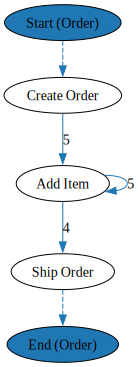

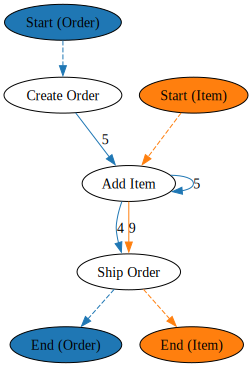

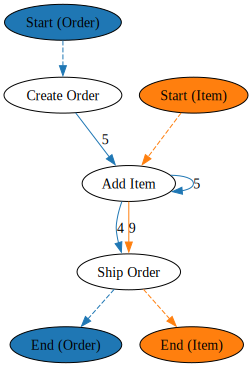

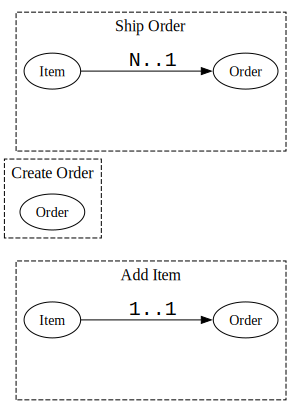

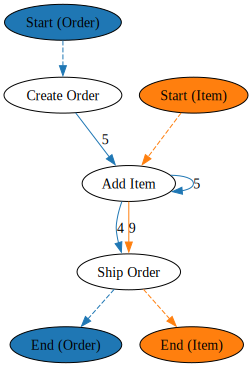

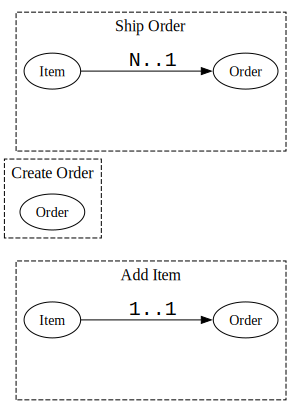

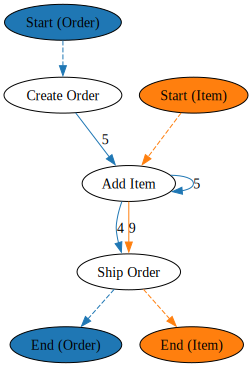

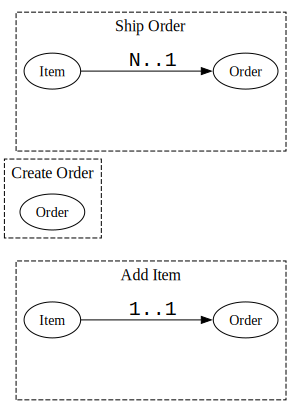

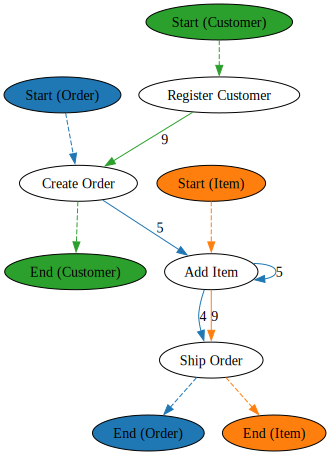

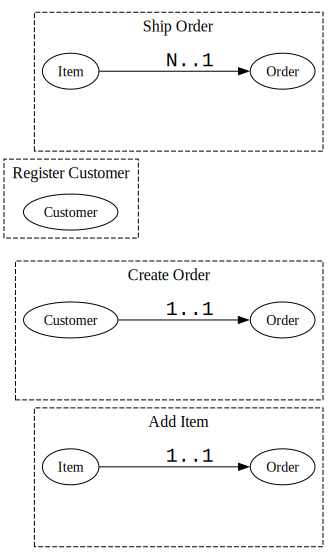

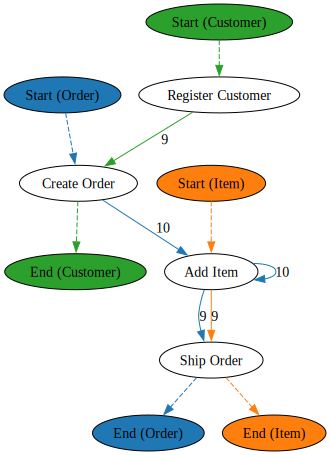

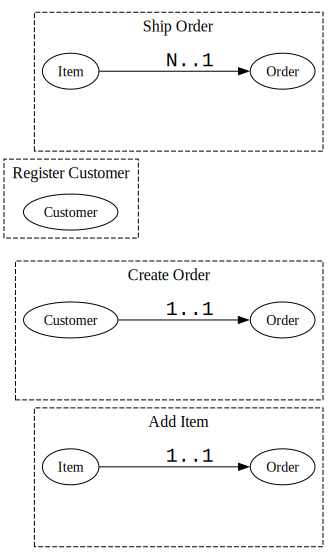

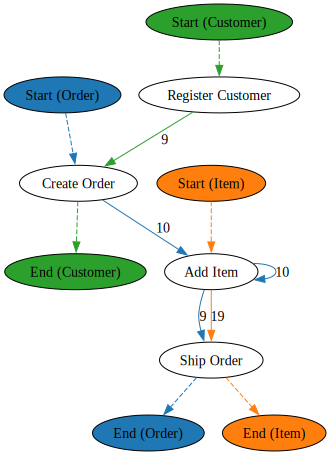

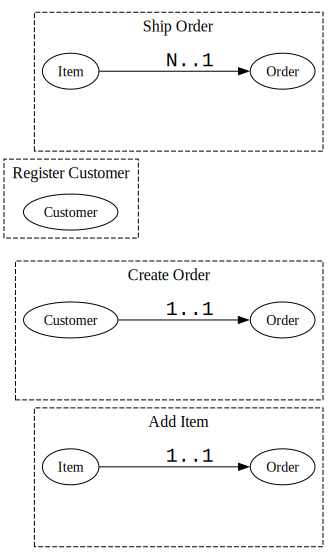

In [5]:
from pybeamline.utils.visualizer import Visualizer
from IPython.display import display
test_source_2 = dict_test_ocel_source(
    [
        (trace_1, 10),  # Repeat trace_1 twice
    ],
    shuffle = False
)
emitted = []
test_source_2.pipe(
    oc_operator(),
    oc_merge_operator(),
).subscribe(
    on_next=lambda x: emitted.append(x)
)

vis = Visualizer()
for i, e in enumerate(emitted):
    if "ocdfg" in e:
            plot = vis.draw_ocdfg(e["ocdfg"])
            display(plot)
    if "aer" in e:
            plot = vis.draw_aer_diagram(e["aer"])
            display(plot)



## Concept Drift
Concept drift is a common challenge in streaming data scenarios, where the underlying data distribution evolves over time. In the context of object-centric process mining, this phenomenon can manifest through changes in the frequency of activities, frequency of object observations, and the structural observed co-occurrence relationships between object-types in activities.

The Object-Centric Framework supports all three types of concept drift detection:
1. **Activity Drift**: Changes in the frequency of activities over time, happens within the same object type.
This is effectively handled by the `HM-LossyCounting` miner, which adapts to changes in activity frequencies by adjusting the model based on the observed data stream.
2. **Object Drift**: Changes in the frequency of object types over time, happens across different object types.
The inclusion strategies provided by the `oc_operator` allow for dynamic adaptation to changes in object type frequencies, ensuring that the model remains relevant.
Here the `RelativeFrequencyBasedStrategy`, `LossyCountingStrategy`, and `SlidingWindowStrategy` can be used to manage the inclusion of object types based on their observed frequencies.
3. **Structural Drift**: Changes in the structural relationships between object types, such as changes in co-occurrence patterns.
The `AER-LC` miner can be used to detect changes in the structural relationships between object types, allowing for the identification of structural drift.



First lets consider concept drift in the realm of `OCDFG`:

In [6]:
from typing import Any
from pybeamline.stream.base_sink import BaseSink
from river import drift

trace_1 = [
            {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
            {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
            {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
            {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i2"]}},
            {"activity": "Ship Order", "objects": {"Item": ["i1", "i2"], "Order": ["o1"]}}
        ]

trace_2 = [
            {"activity": "Register Guest", "objects": {"Guest": ["g1"]}},
            {"activity": "Create Booking", "objects": {"Guest": ["g1"], "Booking": ["b1"]}},
            {"activity": "Reserve Room", "objects": {"Booking": ["b1"]}},
            {"activity": "Check In", "objects": {"Guest": ["g1"], "Booking": ["b1"]}},
            {"activity": "Check Out", "objects": {"Guest": ["g1"], "Booking": ["b1"]}}
        ]

trace_1_set = { ("Register Customer", "Customer", "Create Order"),
                ("Create Order", "Order", "Add Item"),
                ("Add Item", "Order", "Add Item"),
                ("Add Item", "Order", "Ship Order") }

trace_2_set = { ("Register Guest", "Guest", "Create Booking"),
                ("Create Booking", "Guest", "Check In"),
                ("Create Booking", "Booking", "Reserve Room"),
                ("Reserve Room", "Booking", "Check In"),
                ("Check In", "Booking", "Check Out"),
                ("Check In", "Guest", "Check Out") }

concept_drift_source = dict_test_ocel_source(
    [
        (trace_1, 40),  # Repeat trace_1 30 times
        (trace_2, 40)   # Repeat trace_2 ten times
    ],
    shuffle = False
)

# Three different strategies for handling concept drift are available:
inclusion_strategies = {
    "Relative Frequency": RelativeFrequencyBasedStrategy(frequency_threshold=0.10),
    "Lossy Counting": LossyCountingStrategy(max_approx_error=0.2),
    "Sliding Window": SlidingWindowStrategy(window_size=5)
}

class DriftDetector(BaseSink[Any]):

    def __init__(self):
        self.drift_detector = drift.ADWIN()

        self.similarities_1 = []  # to trace_1
        self.similarities_2 = []  # to trace_2
        self.drift_points = []
        self.index = 0

    def consume(self, item: Any) -> None:
        if "ocdfg" in item:
            edge_set = self.conform_emit_ocdfg(item["ocdfg"])

            sim_1 = self.jaccard_similarity(edge_set, trace_1_set)
            sim_2 = self.jaccard_similarity(edge_set, trace_2_set)
            self.similarities_1.append(sim_1)
            self.similarities_2.append(sim_2)

            # Use divergence from trace_1 as signal to drift detector
            self.drift_detector.update(1 - sim_1)
            if self.drift_detector.drift_detected:
                print(f"⚠️ Drift detected at index {self.index}")
                self.drift_points.append(self.index)

            self.index += 1

    # Define a function to extract OCDFG edge set
    @classmethod
    def conform_emit_ocdfg(cls, ocdfg: OCDFG):
        """
        Convert OCDFG to a set of edges in the format (source, object_type, target).
        """
        result = set()
        for obj_type, transitions in ocdfg.edges.items():
            for (src, tgt), freq in transitions.items():
                result.add((src, obj_type, tgt))
        return result

    # Define Jaccard similarity
    @classmethod
    def jaccard_similarity(cls, set_a, set_b):
        union = set_a | set_b
        intersection = set_a & set_b
        return len(intersection) / len(union) if union else 1.0

results = {}
for name, strategy in inclusion_strategies.items():
    drift_detector = DriftDetector()

    # Run the pipeline
    concept_drift_source.pipe(
        oc_operator(inclusion_strategy=strategy),
        oc_merge_operator()
    ).subscribe(drift_detector)

    # Store results for plotting later
    results[name] = {
        "similarities_trace_1": drift_detector.similarities_1,
        "similarities_trace_2": drift_detector.similarities_2,
        "drift_points": drift_detector.drift_points
    }


NameError: name 'RelativeFrequencyBasedStrategy' is not defined

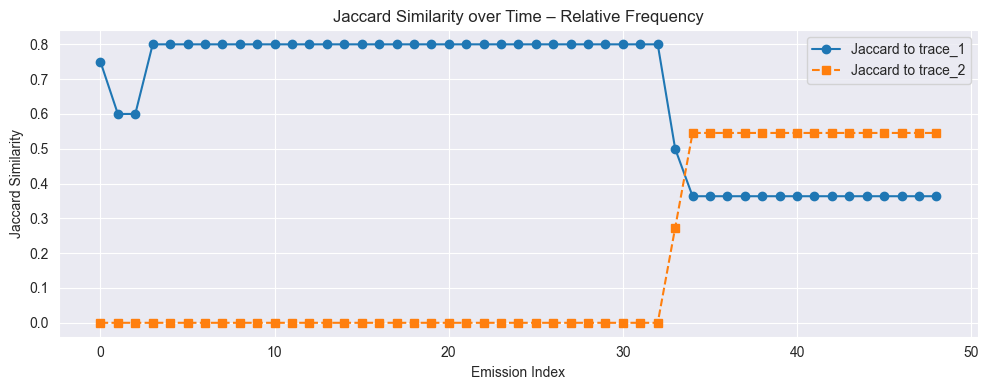

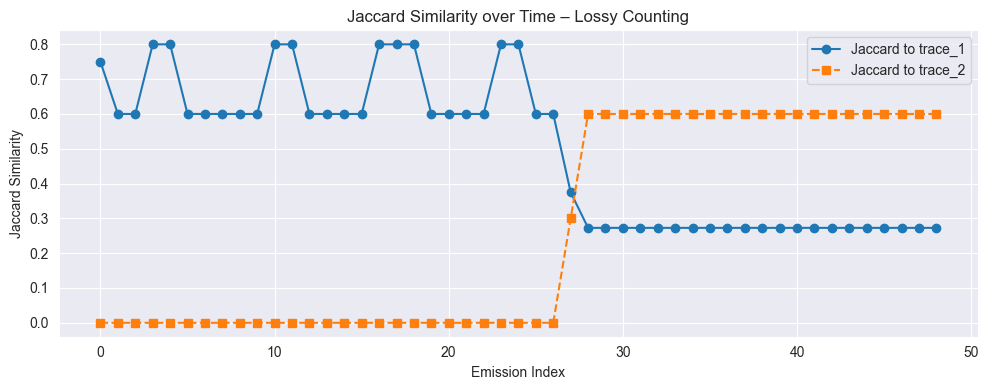

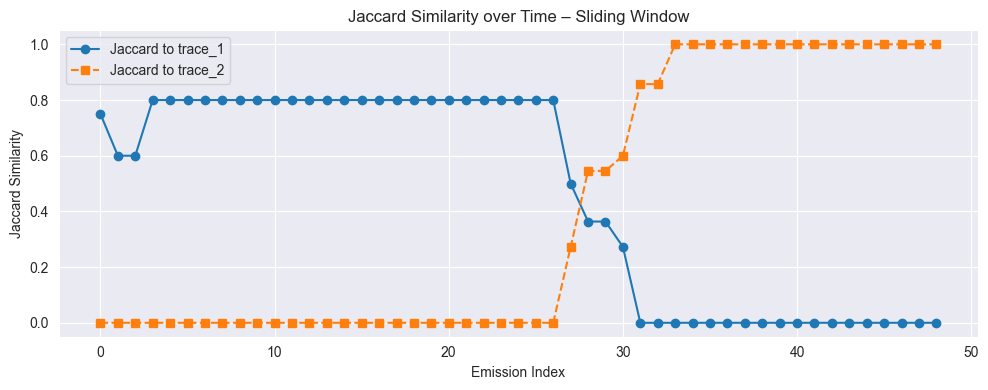

In [69]:
import matplotlib.pyplot as plt
for strategy_name, data in results.items():
        sim_1 = data["similarities_trace_1"]
        sim_2 = data["similarities_trace_2"]
        drifts = data["drift_points"]

        plt.figure(figsize=(10, 4))
        plt.plot(sim_1, label="Jaccard to trace_1", marker='o', linestyle='-')
        plt.plot(sim_2, label="Jaccard to trace_2", marker='s', linestyle='--')

        for drift_index in drifts:
            plt.axvline(drift_index, color='red', linestyle='--', alpha=0.6)

        plt.title(f"Jaccard Similarity over Time – {strategy_name}")
        plt.xlabel("Emission Index")
        plt.ylabel("Jaccard Similarity")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Activity-Entity Relationship (AER) Diagrams

**Activity-Entity Relationship (AER) diagrams** provide a structural view of how object types have been observed per activitivity. AER diagrams emphasize **which object types participate in each activity**, and how they relate to each other within the context of a single event.

Each activity is connected to one or more object types, and directed edges represent **relationships between object types** observed during that activity. These relationships can also be annotated with **cardinality**, such as *one-to-one* or *many-to-one*, helping to identify interaction patterns and potential structural shifts (e.g., through concept drift).

AER diagrams are particularly useful for:

* Understanding object interactions per activity
* Detecting changes in process structure over time
* Complementing control-flow models like OCDFGs with structural context



In [74]:
### Drift Detection in AER Diagrams
from typing import Any

from pybeamline.algorithms.discovery import heuristics_miner_lossy_counting
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source
from pybeamline.stream.base_sink import BaseSink
from pybeamline.utils.cardinality import Cardinality


log_1 = [{"activity": "Add Item", "objects": {"Order": ["o2"], "Item": ["i3"]}}]
log_2 = [{"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1", "i2"]}}]

source1 = dict_test_ocel_source([(log_1, 25), (log_2, 10)], shuffle=True)
source2 = dict_test_ocel_source([(log_1, 10), (log_2, 50)], shuffle=True)
source = source1.concat(source2) # Concatenate two sources to simulate a stream with concept drift where object type co-occurrnce changes over time

class HandleSnapshotSink(BaseSink[Any]):

    def __init__(self):
        self.item_counts = []
        self.cardinalities = []

    def consume(self, snapshot: Any) -> None:
        if snapshot.get("type") == "aer":
            aer = snapshot["model"]
            item_count = None

            # Get average number of "Item" objects per "Add Item" activity
            if "Add Item" in aer.activities:
                for activity, obj_types in aer.object_types.items():
                    if activity == "Add Item" and "Item" in obj_types:
                        # Try estimating item count from some known data (mocked here)
                        item_count = 2 if Cardinality.MANY_TO_ONE in aer.get_relations("Add Item").values() else 1

            # Store results
            self.item_counts.append(item_count)
            if Cardinality.ONE_TO_ONE in aer.get_relations("Add Item").values():
                self.cardinalities.append(0)
            else:
                self.cardinalities.append(1)

snapshot_handler = HandleSnapshotSink()
miner = lambda: heuristics_miner_lossy_counting(model_update_frequency=1)
source.pipe(
    oc_operator(default_miner=miner, aer_model_update_frequency=1, aer_model_max_approx_error=0.01),
).sink(snapshot_handler)


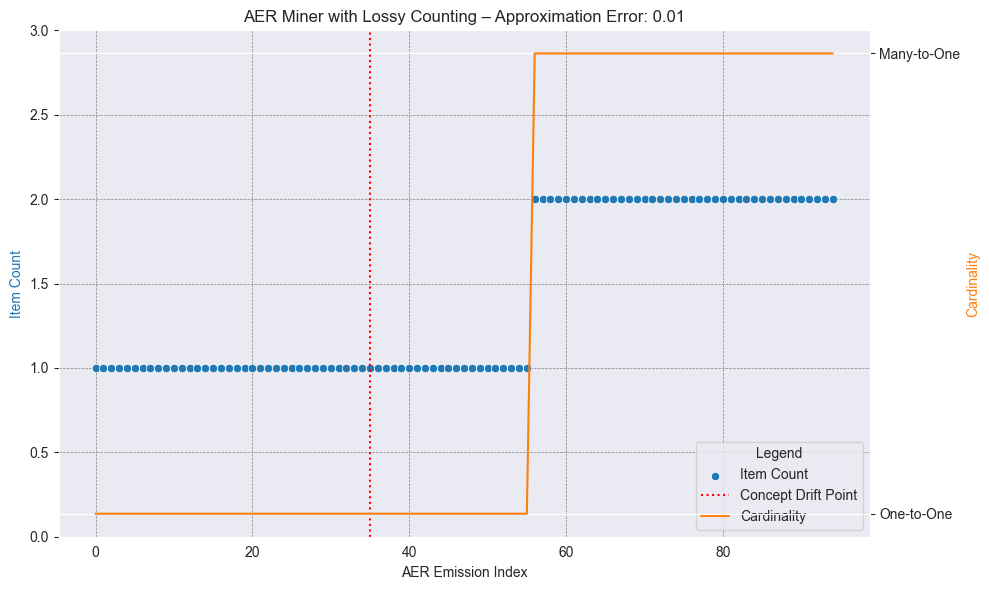

In [73]:
# --- Prepare DataFrame ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    "Emission": list(range(len(snapshot_handler.item_counts))),
    "Item Count": snapshot_handler.item_counts,
    "Cardinality": snapshot_handler.cardinalities
})
df["Cardinality Label"] = df["Cardinality"].map({0: "One-to-One", 1: "Many-to-One"})

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=df, x="Emission", y="Item Count", ax=ax1, label="Item Count", color="tab:blue")
ax1.set_ylabel("Item Count", color="tab:blue")
ax1.set_ylim(0, 3)
ax1.set_xlabel("AER Emission Index")
ax1.axvline(x=35, color='red', linestyle=':', linewidth=1.5, label='Concept Drift Point')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Secondary axis for cardinality
ax2 = ax1.twinx()
sns.lineplot(data=df, x="Emission", y="Cardinality", ax=ax2, label="Cardinality", color="tab:orange")
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["One-to-One", "Many-to-One"])
ax2.set_ylabel("Cardinality", color="tab:orange")
ax2.legend_.remove()

# Combined legend
lines_labels = ax1.get_legend_handles_labels()
lines_labels2 = ax2.get_legend_handles_labels()
lines = lines_labels[0] + lines_labels2[0]
labels = lines_labels[1] + lines_labels2[1]
ax1.legend(lines, labels, loc="lower right", title="Legend")

plt.title("AER Miner with Lossy Counting – Approximation Error: 0.01")
plt.tight_layout()
plt.show()
